## Imports modules

In [1]:
import numpy as np

# to get and read data
import os
import requests
from zipfile import ZipFile
from scipy.io import arff

# to plot the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## get and read data

get data

In [2]:
# download zip

if not os.path.exists('CharacterTrajectories.zip'):
    url = 'http://www.timeseriesclassification.com/Downloads/CharacterTrajectories.zip'
    r = requests.get(url, allow_redirects=True)
    open('CharacterTrajectories.zip', 'wb').write(r.content)
    print('zip downloaded')
else:
    print('zip already exists')


# extract folder from zip
if not os.path.exists('CharacterTrajectories'):
    with ZipFile('CharacterTrajectories.zip', 'r') as zipObj:
      # Extract all the contents of zip file in current directory
      zipObj.extractall('CharacterTrajectories')
    print('folder extracted from zip')
else:
    print('zip already extracted')

zip downloaded
folder extracted from zip


Read data

In [65]:
# ignoring metadata at index 1, arff -> (data,meta)
train_data = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TRAIN.arff')[0]
test_data = arff.loadarff('CharacterTrajectories/CharacterTrajectories_TEST.arff')[0]

In [66]:
def preprocess(data):
  data1 = []
  for sample in data:
    channels = sample[0]
    # subtract 1 since indexes begin from 0
    label = int(sample[1]) - 1
    
    channels1 = []
    for channel in channels:
      values1 = []
      for value in channel:
        if np.isnan(value):
          # replace nan with 0
          values1.append(0.0)
        else:
          values1.append(value)  
      channels1.append(values1)
    data1.append([channels1,label])
    
  data1 = np.array(data1)  
  return data1    

In [67]:
train_data = preprocess(train_data)
test_data = preprocess(test_data)

classes = ['a','b','c','d','e','g','h','l','m','n','o','p','q','r','s','u','v','w','y','z']
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')
print('each channel is 182 in length')

number of classes : 20

train data contains 1422 samples
test data contains 1436 samples

each sample has 3 channels : x,y and force
each channel is 182 in length


function to plot char

In [68]:
def plot_charVector(char):
    
    xVel  = char[0]
    yVel  = char[1]
    force = char[2]
    
    xPos  = np.cumsum(xVel)
    yPos  = np.cumsum(yVel)
    #remove last element and insert 0 to the beginning
    xPos  = np.insert(xPos[:-1],0,0)
    yPos  = np.insert(yPos[:-1],0,0)    
    
    #normalize force between 0 and 1
    color = (force - np.min(force)) / (np.max(force)-np.min(force))
    #define color based on force
    colormap = cm.inferno
    
    plt.quiver( xPos,yPos, xVel,yVel, color=colormap(color) )
    
    plt.show()

In [69]:
def plot_char(char):
    
    xVel  = char[0]
    yVel  = char[1]
    
    xPos  = np.cumsum(xVel)
    yPos  = np.cumsum(yVel)
    
    plt.plot( xPos,yPos )
    
    plt.show()

visualize one character of each class

a


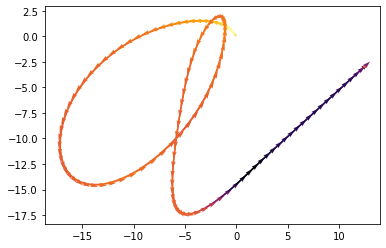

b


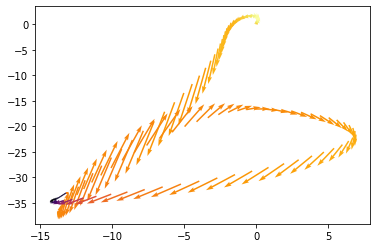

c


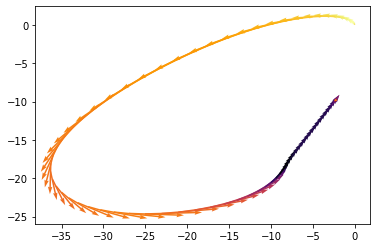

d


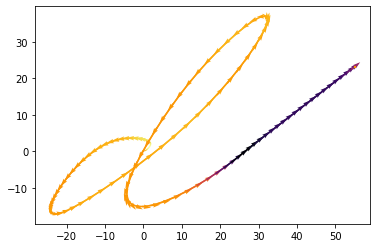

e


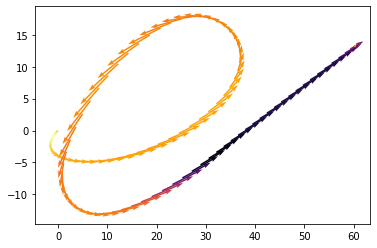

g


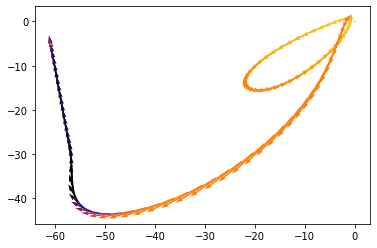

h


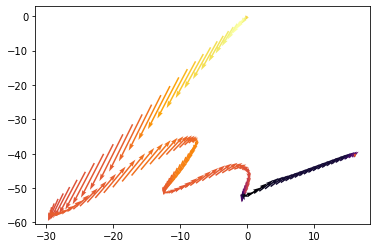

l


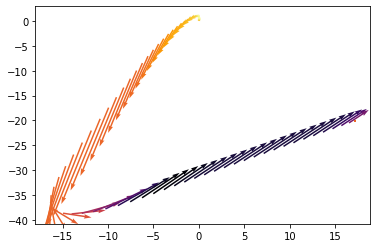

m


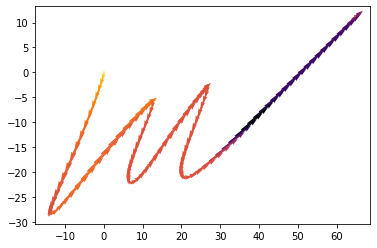

n


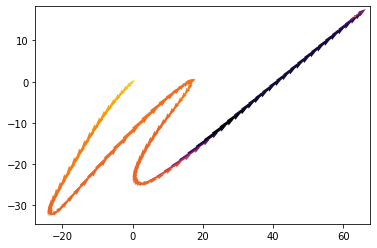

o


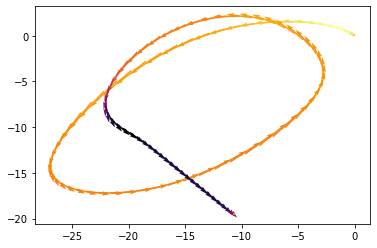

p


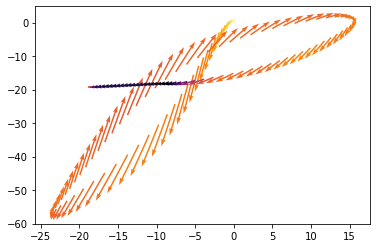

q


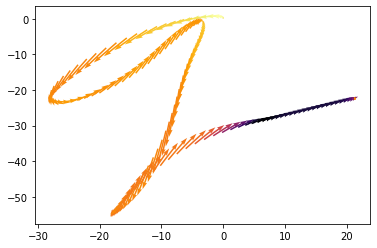

r


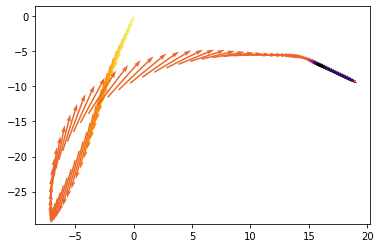

s


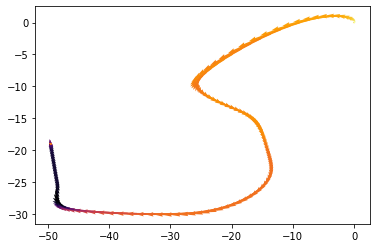

u


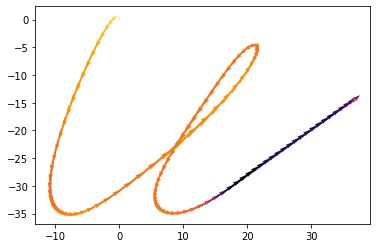

v


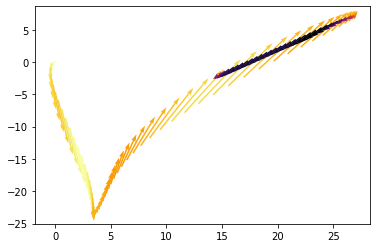

w


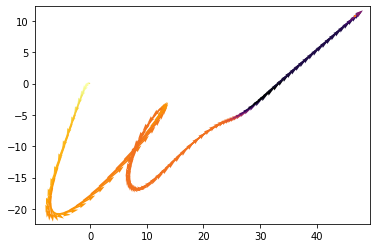

y


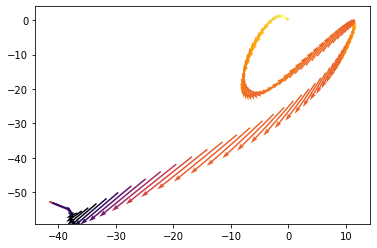

z


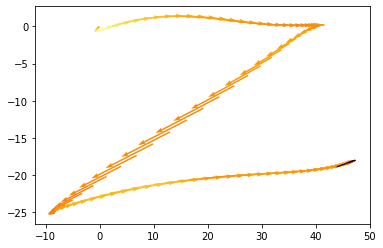

In [93]:
labels = []
for sample in train_data:
  labels.append(sample[1])
labels = np.array(labels)

for i,class1 in enumerate(classes):
  indexes = np.where(labels==i)[0]
  np.random.seed(0)
  random_index = np.random.choice(indexes)
  print(class1)
  plot_charVector(train_data[random_index][0])

function to return patch

In [86]:
def patch(data,length,stride,channels):
  patch = []
  tmp = []

  l = len(data)
  np.random.seed(0)
  random_index = np.random.randint(l)
  sample = data[random_index]
  channels1 = sample[0]
  
  for i in channels:
    tmp1 = []
    for j in range(0,len(channels1[i]),stride):
      tmp1.append(channels1[i][j])
      if len(tmp1) == length:
        break
    tmp.append(tmp1)    

  tmp = np.array(tmp)
  patch.append(tmp)
  patch.append(random_index)
  patch = np.array(patch)

  return patch

[[ 0.118818 -0.532881 -0.631835  0.252319  1.198614  1.312562 -0.340865
  -0.230314  0.900964  1.808771  1.473448]
 [-0.166677 -1.939234 -1.301238  0.087782  1.284402  0.798482 -1.102029
  -0.501484  0.601384  1.127041  0.89638 ]]


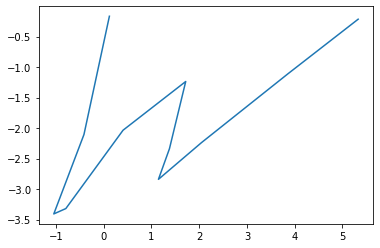

In [104]:
sample_patch = patch(train_data, length=11, stride=10, channels=[0,1])
print(sample_patch[0])
plot_char(sample_patch[0])